In [ ]:
"""
Encoder-Decoder Sequence-to-Sequence Model for Machine Translation from aphasic to correct phrase in English
authors:
    Damiano Pasquini damiano23@ru.is
    Andrea Terenziani andrea23@ru.is
    Aurora Ayn Wickstrom aurora23@ru.is
course: T-725-MALV, Málvinnsla
"""

import tensorflow as tf
import numpy as np

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Reshape
from keras.callbacks import Callback

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 20  # Number of epochs to train for.
latent_dim = 400  # Latent dimensionality of the encoding space. before it was 256
num_samples = 4000  # Number of samples to train on.
embedding_dim = 100
data_path = 'eng_sents_altered.txt' # Path to the data txt file on disk.
max_input_sentence_length = 30
max_target_sentence_length = 30 #TODO review

In [ ]:
# if running on colab, mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Vectorize the data in one hot encoding
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
input_tokens = set()
target_tokens = set()
lines = open(data_path).read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    for word in input_text.split():
        word = word.removesuffix(".").removesuffix(",").removesuffix(";").removesuffix(":").removesuffix("!").removesuffix("?").removesuffix("'").removesuffix('"').removeprefix("'").removeprefix('"')
        input_tokens.add(word)
    for word in target_text.split():
        word = word.removesuffix(".").removesuffix(",").removesuffix(";").removesuffix(":").removesuffix("!").removesuffix("?").removesuffix("'").removesuffix('"').removeprefix("'").removeprefix('"')
        target_tokens.add(word)
    target_texts.append(target_text)
    for char in input_text:
        input_characters.add(char)
    for char in target_text:
        target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

Source Unique words:  7498
Target Unique words 4103
Number of samples: 4000
Number of unique input char: 78
Number of unique output char: 80
Max sequence length for inputs: 33
Max sequence length for outputs: 32


In [ ]:
print('Source Unique words: ', len(input_tokens))
print('Target Unique words: ', len(target_tokens))
print('Number of samples: ', len(input_texts))
print('Number of unique input char:', num_encoder_tokens)
print('Number of unique output char:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)
print()
print(f"Encoder input shape: {encoder_input_data.shape}")
print(f"Decoder input shape: {decoder_input_data.shape}")
print(f"Decoder target shape: {decoder_target_data.shape}")

Source Unique words:  7498
Target Unique words:  4103
Number of samples:  4000
Number of unique input char: 78
Number of unique output char: 80
Max sequence length for inputs: 33
Max sequence length for outputs: 32

Encoder input shape: (4000, 33, 78)
Decoder input shape: (4000, 32, 80)
Decoder target shape: (4000, 32, 80)


In [ ]:
from tensorflow.python.autograph.operators.py_builtins import max_

# embedding_dim = 100

# Encoder
# dataset = tf.data.TextLineDataset(data_path)
encoder_input_data = tf.squeeze(encoder_input_data)
decoder_input_data = tf.squeeze(decoder_input_data)
decoder_target_data = tf.squeeze(decoder_target_data)
dataset = tf.data.Dataset.from_tensor_slices(((encoder_input_data, decoder_input_data), decoder_target_data))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
test_size = int(0.2 * num_samples)
train_size = num_samples-test_size
validation_size = int(0.1*train_size)
train_size-=validation_size


# Split the dataset
train_dataset = dataset.take(train_size // batch_size)
validation_dataset = dataset.skip(train_size // batch_size)
testing_dataset = validation_dataset.skip(validation_size // batch_size)
# validation_dataset = validation_dataset.take(validation_size // batch_size)

encoder_inputs = Input(shape=(max_encoder_seq_length, num_encoder_tokens), name='input_1')
print(f"Enncoder input shape: {encoder_inputs.shape}")

encoder_reshape = Reshape(target_shape=(max_encoder_seq_length*num_encoder_tokens,), name="encoder_reshape")(encoder_inputs)

encoder_embedding = Embedding(input_dim=num_encoder_tokens, output_dim=embedding_dim, name='embedding_1')(encoder_reshape)
print(f"Enncoder embed shape: {encoder_embedding.shape}")

encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True, name='lstm_1', return_sequences=True)(encoder_embedding)
print(f"Enncoder LSTM shape: {encoder_lstm.shape}")

encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_decoder_seq_length, num_decoder_tokens), name='input_2')
print(f"Decoder input shape: {decoder_inputs.shape}")

decoder_reshape = Reshape(target_shape=(max_decoder_seq_length * num_decoder_tokens,), name="decoder_reshape")(decoder_inputs)

decoder_embedding = Embedding(input_dim=max_decoder_seq_length, output_dim=embedding_dim, name='embedding_2')(decoder_reshape)
print(f"Decoder embed shape: {decoder_embedding.shape}")

decoder_lstm, _, _ = LSTM(latent_dim, return_state=True, name='lstm_2', return_sequences=True)(decoder_embedding, initial_state=encoder_states)
print(f"Decoder LSTM shape: {decoder_lstm.shape}")

decoder_outputs = Dense(len(target_tokens), activation='softmax', name='dense_1')(decoder_lstm)

# Model
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs, name='seq2seq_model')

Enncoder input shape: (None, 33, 78)
Enncoder embed shape: (None, 2574, 100)
Enncoder LSTM shape: (None, 2574, 400)
Decoder input shape: (None, 32, 80)
Decoder embed shape: (None, 2560, 100)
Decoder LSTM shape: (None, 2560, 400)


In [ ]:
model.summary()

Model: "seq2seq_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 33, 78)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 32, 80)]             0         []                            
                                                                                                  
 encoder_reshape (Reshape)   (None, 2574)                 0         ['input_1[0][0]']             
                                                                                                  
 decoder_reshape (Reshape)   (None, 2560)                 0         ['input_2[0][0]']             
                                                                                      

In [ ]:
!pip install graphviz

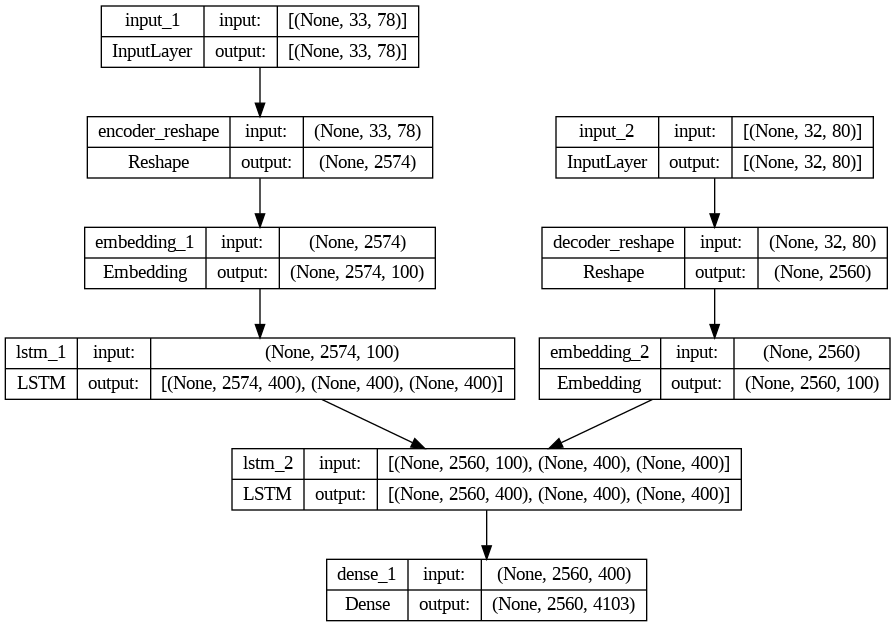

In [ ]:
from keras.utils import plot_model

plot_model(model, show_layer_names=True, show_shapes=True)

In [ ]:
class LogCallback(Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_step_begin(self, step, logs):
        print(f"APAPAPAPAPAPA {step}")

In [ ]:
# Run training
model.compile(optimizer='adagrad', loss='categorical_crossentropy')

In [ ]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)


# [encoder_input_data, decoder_input_data]
model.fit(train_dataset,
          epochs=epochs,
          batch_size=64,
          validation_data=validation_dataset,
          callbacks=[LogCallback()])
# Save model
model.save('s2s.h5')

(4000, 33, 78)
(4000, 32, 80)
Starting training; got log keys: []
Epoch 1/20


ValueError: ignored

In [ ]:

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)